In [1]:
from keras_facenet import FaceNet
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
import os,glob,cv2
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import face_recognition
import numpy as np

In [2]:
embedder = FaceNet()

In [3]:
face_image_dict = {}
for image_file in glob.glob("faces/facedb/*"):
    p_name = image_file.split("\\")[-1].split(".")[0]
    i_face = cv2.imread(image_file,cv2.IMREAD_COLOR)
    i_face = cv2.cvtColor(i_face, cv2.COLOR_BGR2RGB)
    i_face = cv2.resize(i_face, (200,200))
    face_image_dict[p_name] = i_face

In [9]:
encoded_face_db = {}
for key, image in face_image_dict.items():
    input_face = image.reshape(1,200,200,3)
    encoded_face = embedder.embeddings(input_face)[0]
    encoded_face_db[key] = encoded_face

In [10]:
face_df = pd.DataFrame()
face_df["Name"] = encoded_face_db.keys()
face_df["Face_features"] = encoded_face_db.values()

In [11]:
face_df.to_csv("Face_feature_database.csv",index = False)

## Time for recognize faces (run this only to for testing)

In [12]:
face_df = pd.read_csv("Face_feature_database.csv")

In [13]:
face_df

,Name,Face_features
0,ahnaf,"(-0.006323412, 0.00055685977, -0.045486297, -0..."
1,chanchal,"(0.030246848, -0.03178286, 0.0046736016, 0.021..."
2,duti,"(0.0057912455, -0.059497774, 0.0017784744, -0...."
3,guru,"(0.07367235, 0.013556901, -0.03345981, 0.05818..."
4,hasan,"(0.00563607, 0.074914254, -0.022259988, -0.010..."
5,hridoy,"(0.016944043, 0.023342464, -0.054529145, 0.047..."
6,kazi,"(-0.025189998, 0.019663401, -0.048723433, 0.00..."
7,mamoor,"(0.051278513, -0.0154350875, -0.0041040555, -0..."
8,montu,"(0.031406824, 0.03172283, 0.00034240523, 0.048..."
9,moury,"(-0.033528592, -0.0229023, -0.029062154, -0.03..."


In [51]:
test_img = cv2.imread("test.jpeg") #change this image dir to test any images
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
face_locations = face_recognition.face_locations(test_img,number_of_times_to_upsample=1, model="cnn")
face_names = face_df["Name"].values
face_feats = face_df["Face_features"].to_numpy()

In [52]:
face_feats_np = [np.fromstring(x[1:-1],sep=',') for x in face_feats]

In [53]:
def mark_face_in_image():
    pass

In [54]:
print(face_names)

['ahnaf' 'chanchal' 'duti' 'guru' 'hasan' 'hridoy' 'kazi' 'mamoor' 'montu'
 'moury' 'nn' 'rizvy' 'saief' 'salman' 'shissho' 'sokif' 'tahjib' 'tultul'
 'walid']


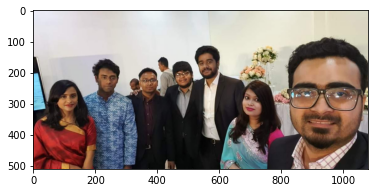

0.7692764045746023 8 montu


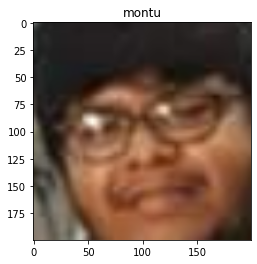

0.9723886790522142 12 saief


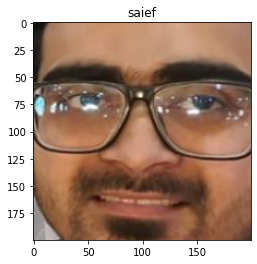

0.9504761375725783 15 sokif


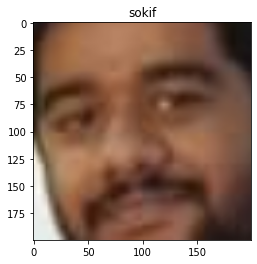

0.5053293569812236 10 nn


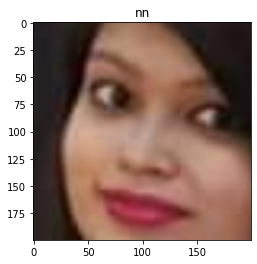

0.6105689387133447 9 moury


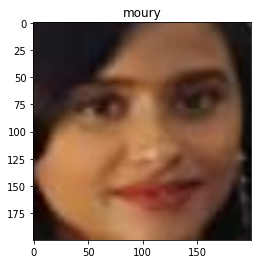

0.42266496593321423 14 shissho


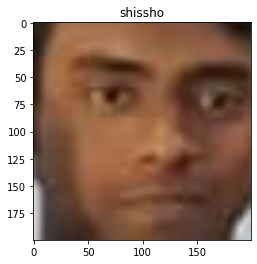

0.5622989478639875 4 hasan


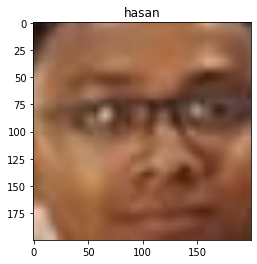

In [55]:
plt.imshow(test_img)
plt.show()
for loc in face_locations:
    top,right,bottom,left = loc
    face = test_img[top:bottom, left:right]
    face = cv2.resize(face,(200,200))
    face = face.reshape(1,200,200,3)
    face_embedding = embedder.embeddings(face)
    simi = cosine_similarity(face_feats_np,face_embedding)
    
    print(simi.max(),simi.argmax(),face_names[simi.argmax()])
    
    plt.imshow(face[0])
    plt.title(face_names[simi.argmax()])
    plt.show()

In [56]:
from annoy import AnnoyIndex
t = AnnoyIndex(len(face_feats_np[0]),"dot")
for i,face in enumerate(face_feats_np):
    t.add_item(i,face)
t.build(2)


True

In [57]:
for loc in face_locations:
    top,right,bottom,left = loc
    face = test_img[top:bottom, left:right]
    face = cv2.resize(face,(200,200))
    face = face.reshape(1,200,200,3)
    face_embedding = embedder.embeddings(face)
    sim = t.get_nns_by_vector(face_embedding[0],n=5,include_distances=True)
    print(face_names[sim[0]])
    print(sim)

['montu' 'guru' 'shissho' 'sokif' 'kazi']
([8, 3, 14, 15, 6], [0.7692761421203613, 0.6272087097167969, 0.5397911071777344, 0.5067538022994995, 0.440615713596344])
['saief' 'sokif' 'tahjib' 'ahnaf' 'shissho']
([12, 15, 16, 0, 14], [0.9723886847496033, 0.5274435877799988, 0.4660116136074066, 0.3734254539012909, 0.36965012550354004])
['sokif' 'salman' 'saief' 'mamoor' 'shissho']
([15, 13, 12, 7, 14], [0.9504761099815369, 0.5082347393035889, 0.5046775937080383, 0.4799393117427826, 0.460773229598999])
['nn' 'tultul' 'moury' 'hasan' 'duti']
([10, 17, 9, 4, 2], [0.5053290724754333, 0.4329689145088196, 0.36843693256378174, 0.3225920796394348, 0.2435014396905899])
['moury' 'hridoy' 'tultul' 'duti' 'nn']
([9, 5, 17, 2, 10], [0.6105690002441406, 0.3147633969783783, 0.2928190529346466, 0.2657944858074188, 0.23154859244823456])
['shissho' 'hridoy' 'mamoor' 'saief' 'sokif']
([14, 5, 7, 12, 15], [0.4226650297641754, 0.4061434864997864, 0.3401149809360504, 0.33532819151878357, 0.28956952691078186])
['

In [58]:
t.save("face_db.ann")

True